In [6]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


In [7]:
def c_amod15(a, power): #Modular Exponentiation Function 
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U
print("Success")

Success


In [8]:
# Specify variables
n_count = 8  # number of counting qubits
a = 7 # Guess Number 'a'

In [9]:
def qft_dagger(n): #Quantum Fourier Transform Circuit
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT dagger"
    return qc

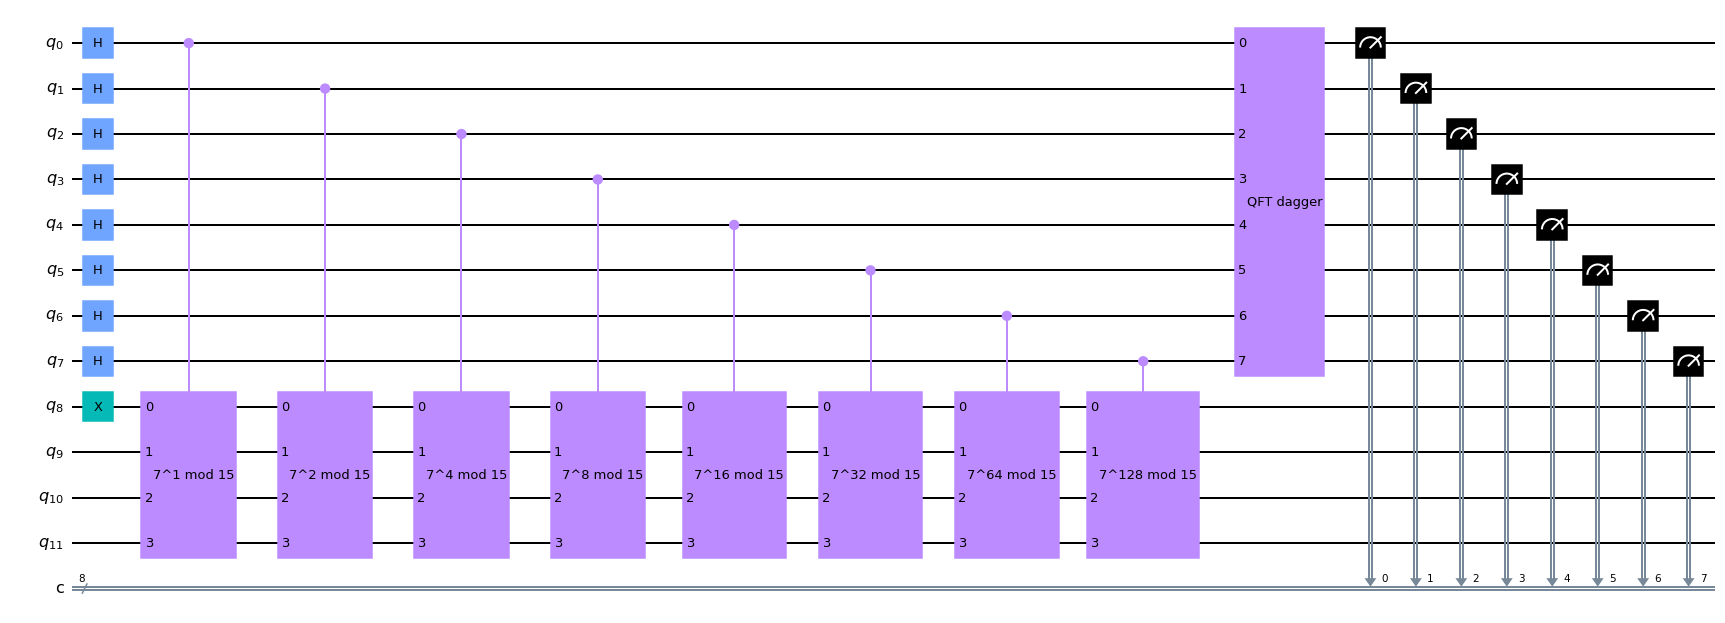

In [12]:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(n_count)

# Modular Exponentiation Function
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), [q] + [i+n_count for i in range(4)])

# Quantum Fourier Transform
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw(fold=-1)  # -1 means 'do not fold' 

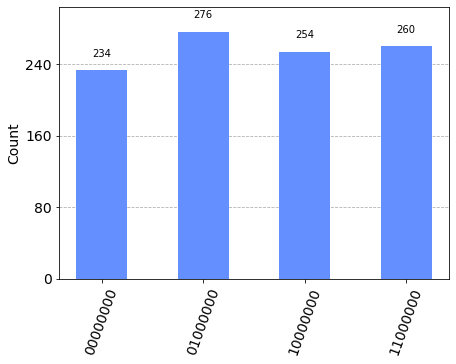

In [20]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc)
results = qasm_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

#Gives back in binary the phases: 0/256, 64/256, 128/256, 192/256
# r = 1, 2, 4
#Notice that 64/256 and 192/256 (r=4) have the two highest counts

In [15]:
rows, measured_phases = [], [] #Converting phases into decimal outputs to find eigenvalues
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  11000000(bin) = 192(dec)  192/256 = 0.75
1  10000000(bin) = 128(dec)  128/256 = 0.50
2  01000000(bin) =  64(dec)   64/256 = 0.25
3  00000000(bin) =   0(dec)    0/256 = 0.00


In [68]:
rows = [] #Takes phase expression and finds a fraction equivalent to extract 'r' (denominator of fraction)
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator, gcd(a**(int)(frac.denominator/2)-1,15), 
                 gcd(a**(int)(frac.denominator/2)+1,15)]) #GCD of 

headers=["Phase", "Fraction", "Guess for r", "P", "Q"]
df = pd.DataFrame(rows, columns=headers)
print(df)

# P and Q represent the two factors

   Phase Fraction  Guess for r   P  Q
0   0.75      3/4            4   3  5
1   0.50      1/2            2   3  1
2   0.25      1/4            4   3  5
3   0.00      0/1            1  15  1
